# Titanic data set example

Note: 
The focus of this example is less on finding anomalies but rather to illustrate model explanability in the case of categorical and continuous features.

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from bhad.utils import Discretize
from bhad.model import BHAD

In [2]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

X.head(2)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
X_cleaned = X.drop(['body', 'cabin', 'name', 'ticket', 'boat'], axis=1).dropna()  # not needed
y_cleaned = y[X_cleaned.index]

X_cleaned.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 684 entries, 0 to 1281
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     684 non-null    int64   
 1   sex        684 non-null    category
 2   age        684 non-null    float64 
 3   sibsp      684 non-null    int64   
 4   parch      684 non-null    int64   
 5   fare       684 non-null    float64 
 6   embarked   684 non-null    category
 7   home.dest  684 non-null    object  
dtypes: category(2), float64(2), int64(3), object(1)
memory usage: 39.0+ KB


Partition dataset:

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.33, random_state=42)

print(X_train.shape)
print(X_test.shape)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(458, 8)
(226, 8)
(array(['0', '1'], dtype=object), array([242, 216]))
(array(['0', '1'], dtype=object), array([122, 104]))


## Train model and create local/global model explanation:

Retrieve local model explanations. Here: Specify all numeric and categorical columns explicitly

In [5]:
num_cols = list(X_train.select_dtypes(include=['float', 'int']).columns) 
cat_cols = list(X_train.select_dtypes(include=['object', 'category']).columns)

Score your train set:

In [6]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    ('discrete', Discretize(nbins = None, verbose = False)),     
    ('model', BHAD(contamination = 0.01, num_features = num_cols, cat_features = cat_cols))
])

y_pred_train = pipe.fit_predict(X_train)


-- Bayesian Histogram-based Anomaly Detector (BHAD) --

Fit BHAD on discretized data.
Input shape: (458, 8)
One-hot encoding categorical features.
Matrix dimension after one-hot encoding: (458, 319)
Finished training.
Score input data.


In [7]:
from bhad import explainer

local_expl = explainer.Explainer(pipe.named_steps['model'], pipe.named_steps['discrete']).fit()

--- BHAD Model Explainer ---

Using fitted BHAD and discretizer.
Marginal distributions estimated using train set of shape (458, 8)


In [8]:
df_train = local_expl.get_explanation(nof_feat_expl = 5)

Create local explanations for 458 observations.


  0%|          | 0/458 [00:00<?, ?it/s]

In [9]:
global_feat_imp = local_expl.global_feat_imp         # based on X_train
global_feat_imp

,avg ranks
embarked,0.152058
sex,0.257304
parch,0.279548
sibsp,0.444223
age,0.491700
fare,0.546813
pclass,0.634462
home.dest,1.000000


### Get global model explanation (in decreasing order):

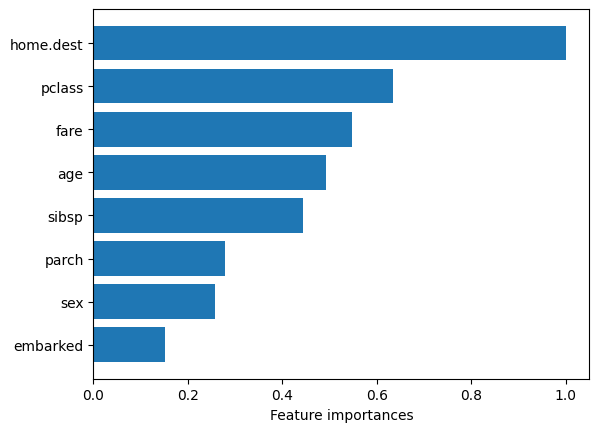

In [10]:
from matplotlib import pyplot as plt

plt.barh(global_feat_imp.index, global_feat_imp.values.flatten())
plt.xlabel("Feature importances");

### Get local explanations, i.e. feature importances (in decreasing order):

In [11]:
for obs, ex in enumerate(df_train.explanation.values):
    if (obs % 100) == 0:
        print(f'\nObs. {obs}:\n', ex)


Obs. 0:
 parch (Cumul.perc.: 0.996): 5.0
home.dest (Perc.: 0.011): Sweden Winnipeg, MN
sex (Perc.: 0.4): female

Obs. 100:
 home.dest (Perc.: 0.002): Tofta, Sweden Joliet, IL
fare (Cumul.perc.: 0.07): 7.78

Obs. 200:
 home.dest (Perc.: 0.013): Brooklyn, NY

Obs. 300:
 home.dest (Perc.: 0.007): Bournmouth, England
age (Cumul.perc.: 0.05): 5.0
sex (Perc.: 0.4): female

Obs. 400:
 home.dest (Perc.: 0.002): Taalintehdas, Finland Hoboken, NJ


In [12]:
y_pred_test = pipe.predict(X_test)


Score input data.
Apply fitted one-hot encoder.


In [13]:
df_test = local_expl.get_explanation(nof_feat_expl = 4)
df_test.head(2)

Create local explanations for 226 observations.


  0%|          | 0/226 [00:00<?, ?it/s]

,pclass,sex,age,sibsp,parch,fare,embarked,home.dest,explanation
0,2.0,male,36.0,1.0,2.0,27.7500,S,"Bournmouth, England","home.dest (Perc.: 0.007): Bournmouth, England"
1,1.0,male,49.0,1.0,1.0,110.8833,C,"Haverford, PA","home.dest (Perc.: 0.007): Haverford, PA\nfare ..."


In [14]:
for obs, ex in enumerate(df_test.explanation.values):
    if (obs % 50) == 0:
        print(f'\nObs. {obs}:\n', ex)


Obs. 0:
 home.dest (Perc.: 0.007): Bournmouth, England

Obs. 50:
 home.dest (Perc.: 0.002): Deephaven, MN / Cedar Rapids, IA
fare (Cumul.perc.: 0.91): 106.42

Obs. 100:
 home.dest (Perc.: 0.002): Hudson, NY
sex (Perc.: 0.4): female

Obs. 150:
 home.dest (Perc.: 0.0): ?Havana, Cuba

Obs. 200:
 embarked (Perc.: 0.048): Q
home.dest (Perc.: 0.0): Co Sligo, Ireland Hartford, CT
sex (Perc.: 0.4): female
fare (Cumul.perc.: 0.061): 7.75


In [15]:
local_expl.global_feat_imp   # based on X_test

,avg ranks
embarked,0.157711
parch,0.245639
sex,0.256804
sibsp,0.441731
age,0.480112
fare,0.575715
pclass,0.638521
home.dest,1.000000
